In [1]:
"""We define the class for simulating the Hindmarsh-Rose model."""
import torch
import matplotlib.pyplot as plt
import math
from spectrum_general.spectrum import PSD
from model_classes.hindmarsh_rose import HR
from spectrum_general.matrix_spectrum import matrix_solution
from spectrum_general.sim_spectrum import sim_solution
from spectrum_general.recursive_spectrum import recursive_solution
import numpy as np
import os

os.chdir('..')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

fileloc = r'figures/HR/'

In [13]:
"""Define the colors for the different methods"""
color_recursive = '#FFA353'
color_elementwise =  '#095400'
color_matrix =  '#1B3B9D'
color_sim = 'k'

linewidth_recursive = 12
linewidth_elementwise = 3.5
marker_matrix = 8
simulation_marker = 12

font_size = 28

In [2]:
"""Define the HR circuit"""
eta1 = 0.001
I = 5.5
model = HR(eta1=eta1, I=I)

In [3]:
"""Define the simulation parameters"""
ndivs = 10
n_points = int(1e6)
time = 50000
dt = 0.04

In [4]:
"""Define the frequency vectors"""
min_freq = 1e-4
max_freq = 10
n_freq_mat = 60
n_freq_rat = 1000

"""Define the frequency vectors for the matrix and rational solutions"""
freq_mat = torch.logspace(np.log10(min_freq), np.log10(max_freq), n_freq_mat)
freq_rat = torch.logspace(np.log10(min_freq), np.log10(max_freq), n_freq_rat)

In [5]:
"""Find auto-spectra of x using different schemes"""
idx = 0

"""Analytical solution (matrix)"""
mat_model = matrix_solution(model.J, model.L, model.S)
psd_matrix, _ = mat_model.auto_spectrum(idx, freq_mat)

"""Analytical solution (elementwise)"""
rat_model = PSD(model.J, model.L, model.S)
psd_rational, _ = rat_model.auto_spectrum(idx, freq_rat)

"""Analytical solution (recursive algorithm)"""
recursive_model = recursive_solution(model.J, model.L, model.S)
psd_recursive, _ = recursive_model.auto_spectrum(idx, freq_rat)

"""Simulation solution"""
sim_model = sim_solution(model)
psd_sim, f = sim_model.simulation_spectrum(i=idx, ndivs=ndivs, n_points=n_points, time=time, dt=dt)

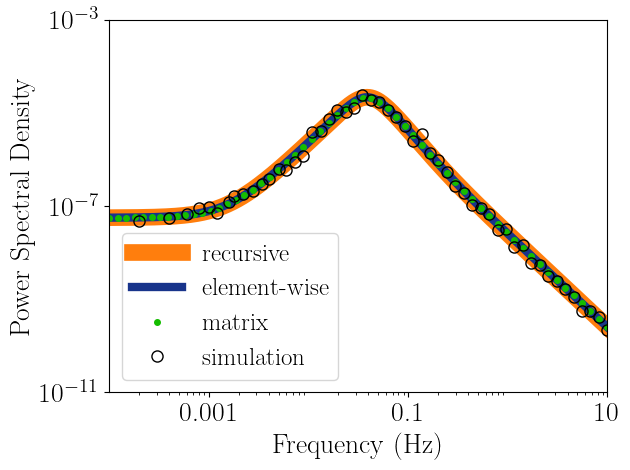

In [50]:
plt.figure(1)
idx_closest = torch.unique(torch.abs(f[1:, None] - freq_mat).argmin(axis=0)) + 1
plt.loglog(freq_rat, psd_recursive, label='recursive', linewidth=linewidth_recursive, color=color_recursive)
plt.loglog(freq_rat, psd_rational, label='element-wise', linewidth=linewidth_elementwise, color=color_elementwise)
plt.loglog(freq_mat, psd_matrix, label='matrix', linewidth=0, marker='s', markersize=marker_matrix, color=color_matrix)
plt.loglog(f[idx_closest], psd_sim[idx_closest], label='simulation', linewidth=0, marker='o', markersize=8, markerfacecolor='none',color=color_sim)
plt.legend(fontsize=18, loc='lower left')
plt.xlabel('Frequency (Hz)', fontsize=20)
plt.ylabel('Power Spectral Density', fontsize=20)
plt.xticks([1e-3, 1e-1, 10], ['0.001', '0.1', '10'], fontsize=20)
plt.yticks([1e-11, 1e-7, 1e-3], fontsize=20)
plt.xlim([1e-4, 10])
plt.ylim([1e-11, 1e-3])
plt.tight_layout()
plt.savefig(fileloc + 'psd_hr.svg', format='svg', dpi=1200)
plt.show()

In [6]:
"""Plot the simulated spectrum of the membrane potential and the one using the formula"""
idx = 0

"""Simulation spectrum"""
sim_model = sim_solution(model)
psd_sim, f = sim_model.simulation_spectrum(i=idx, ndivs=ndivs, n_points=n_points, time=time, dt=dt)

"""Formula spectrum"""
f_psd = model.psd_x(freq_rat)

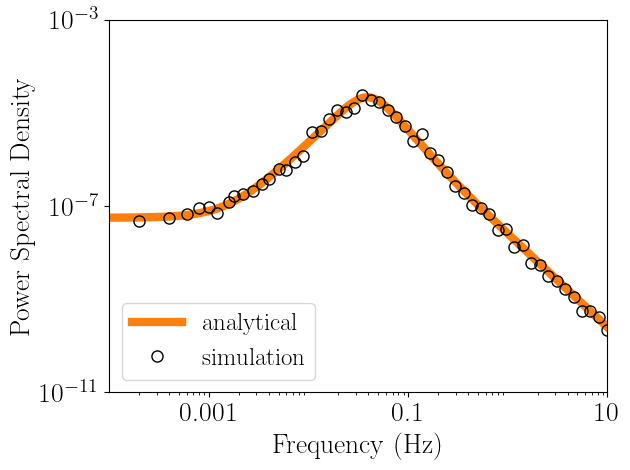

In [52]:
plt.figure(2)
idx_closest = torch.unique(torch.abs(f[1:, None] - freq_mat).argmin(axis=0)) + 1
plt.loglog(freq_rat, f_psd, label='analytical', linewidth=6, color='C1')
plt.loglog(f[idx_closest], psd_sim[idx_closest], label='simulation', linewidth=0, marker='o', markersize=8, markerfacecolor='none',color='k')
plt.legend(fontsize=18, loc='lower left')
plt.xlabel('Frequency (Hz)', fontsize=20)
plt.ylabel('Power Spectral Density', fontsize=20)
plt.xticks([1e-3, 1e-1, 10], ['0.001', '0.1', '10'], fontsize=20)
plt.yticks([1e-11, 1e-7, 1e-3], fontsize=20)
plt.xlim([1e-4, 10])
plt.ylim([1e-11, 1e-3])
plt.tight_layout()
plt.savefig(fileloc + 'psd_hr_formula.svg', format='svg', dpi=1200)
plt.show()

In [7]:
"""Plot the cross-spectrum between x and y"""
i = 0
j = 1

"""Analytical solution (matrix)"""
mat_model = matrix_solution(model.J, model.L, model.S)
cpsd_matrix, _ = mat_model.cross_spectrum(i, j, freq_mat)

"""Analytical solution (elementwise)"""
rat_model = PSD(model.J, model.L, model.S)
cpsd_rational, _ = rat_model.cross_spectrum(i, j, freq_rat)

"""Analytical solution (recursive algorithm)"""
recursive_model = recursive_solution(model.J, model.L, model.S)
cpsd_recursive, _ = recursive_model.cross_spectrum(i, j, freq_rat)

"""Simulation solution"""
sim_model = sim_solution(model)
cpsd_sim, f = sim_model.simulation_spectrum(i=i, j=j, ndivs=ndivs, n_points=n_points, time=time, dt=dt)

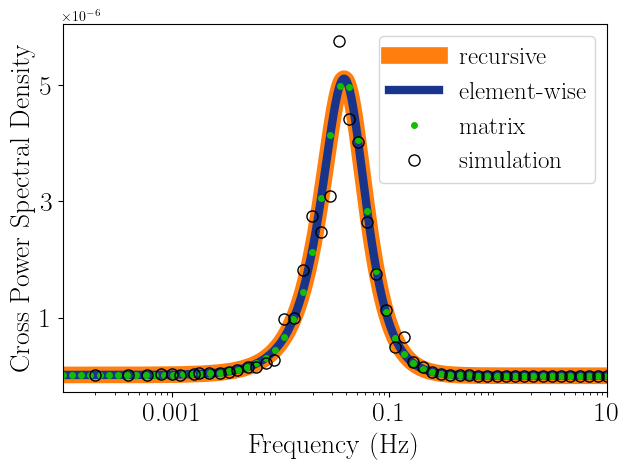

In [54]:
plt.figure(3)
idx_closest = torch.unique(torch.abs(f[1:, None] - freq_mat).argmin(axis=0)) + 1
plt.semilogx(freq_rat, torch.abs(cpsd_recursive), label='recursive', linewidth=linewidth_recursive, color=color_recursive)
plt.semilogx(freq_rat, torch.abs(cpsd_rational), label='element-wise', linewidth=linewidth_elementwise, color=color_elementwise)
plt.semilogx(freq_mat, torch.abs(cpsd_matrix), label='matrix', linewidth=0, marker='s', markersize=marker_matrix, color=color_matrix)
plt.semilogx(f[idx_closest], torch.abs(cpsd_sim[idx_closest]), label='simulation', linewidth=0, marker='o', markersize=8, markerfacecolor='none', color='k')
plt.legend(fontsize=18, loc='upper right')
plt.xlabel('Frequency (Hz)', fontsize=20)
plt.ylabel('Cross Power Spectral Density', fontsize=20)
plt.xticks([1e-3, 1e-1, 10], ['0.001', '0.1', '10'], fontsize=20)
plt.xlim([1e-4, 10])
plt.yticks([1e-6, 3e-6, 5e-6], fontsize=20)
# plt.ylim([1e-10, 1e-5])
plt.tight_layout()
plt.savefig(fileloc + 'cpsd_hr_absolute.svg', format='svg', dpi=1200)
plt.show()

In [8]:
"""Plot the coherence between x and y"""
i = 0
j = 1

"""Analytical solution (matrix)"""
mat_model = matrix_solution(model.J, model.L, model.S)
coh_matrix, _ = mat_model.coherence(i=i, j=j, freq=freq_mat)

"""Analytical solution (elementwise)"""
rat_model = PSD(model.J, model.L, model.S)
coh_rational, _ = rat_model.coherence(i, j, freq_rat)

"""Analytical solution (recursive algorithm)"""
recursive_model = recursive_solution(model.J, model.L, model.S)
coh_recursive, _ = recursive_model.coherence(i, j, freq_rat)

"""Simulation solution"""
sim_model = sim_solution(model)
coh_sim, f = sim_model.simulation_coherence(i=i, j=j, ndivs=ndivs, n_points=n_points, time=time, dt=dt)

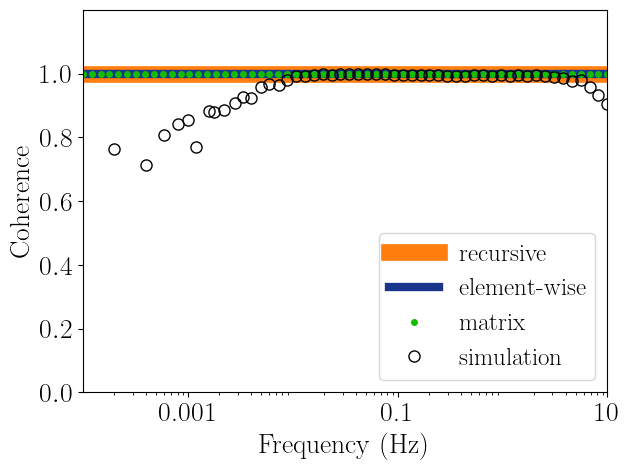

In [56]:
plt.figure(4)
idx_closest = torch.unique(torch.abs(f[1:, None] - freq_mat).argmin(axis=0)) + 1
plt.semilogx(freq_rat, torch.abs(coh_recursive), label='recursive', linewidth=linewidth_recursive, color=color_recursive)
plt.semilogx(freq_rat, torch.abs(coh_rational), label='element-wise', linewidth=linewidth_elementwise, color=color_elementwise)
plt.semilogx(freq_mat, torch.abs(coh_matrix), label='matrix', linewidth=0, marker='s', markersize=marker_matrix, color=color_matrix)
plt.semilogx(f[idx_closest], torch.abs(coh_sim[idx_closest]), label='simulation', linewidth=0, marker='o', markersize=8, markerfacecolor='none', color='k')
plt.legend(fontsize=18, loc='lower right')
plt.xlabel('Frequency (Hz)', fontsize=20)
plt.ylabel('Coherence', fontsize=20)
plt.xticks([1e-3, 1e-1, 10], ['0.001', '0.1', '10'], fontsize=20)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=20)
plt.xlim([1e-4, 10])
plt.ylim([0, 1.2])
plt.tight_layout()
plt.savefig(fileloc + 'coh_hr.svg', format='svg', dpi=1200)
plt.show()

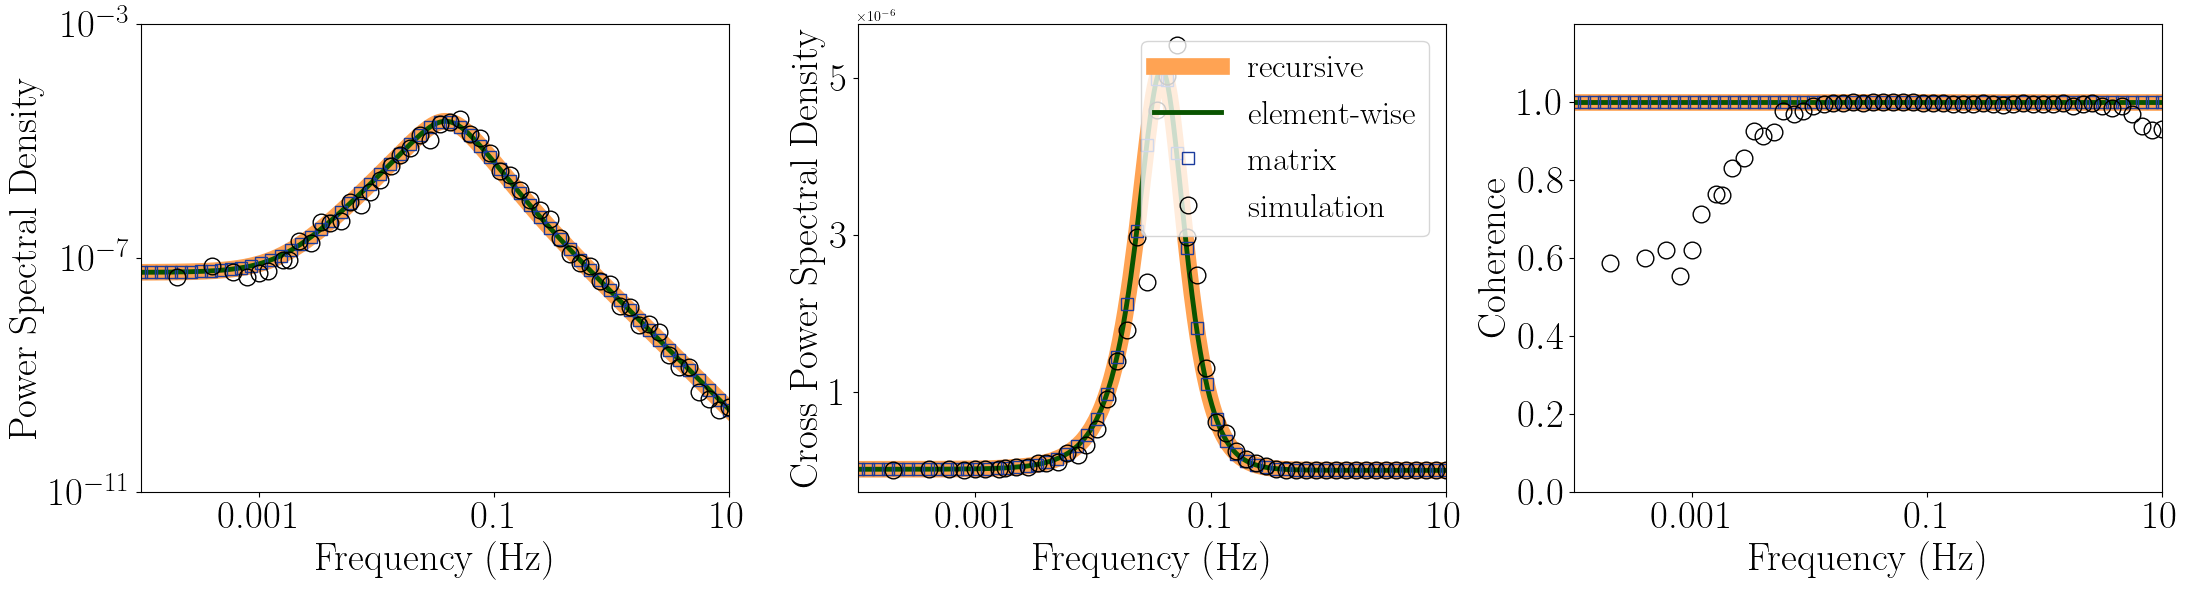

In [14]:
"""Combined figures"""
fig, ax = plt.subplots(1, 3, figsize=(22, 6))

idx_closest = torch.unique(torch.abs(f[1:, None] - freq_mat).argmin(axis=0)) + 1
ax[0].loglog(freq_rat, psd_recursive, label='recursive', linewidth=linewidth_recursive, color=color_recursive)
ax[0].loglog(freq_rat, psd_rational, label='element-wise', linewidth=linewidth_elementwise, color=color_elementwise)
ax[0].loglog(freq_mat, psd_matrix, label='matrix', linewidth=0, marker='s',markerfacecolor='none', markersize=marker_matrix, color=color_matrix)
ax[0].loglog(f[idx_closest], psd_sim[idx_closest], label='simulation', linewidth=0, marker='o', markersize=simulation_marker, markerfacecolor='none',color='k')
# ax[0].legend(fontsize=18, loc='lower left')
ax[0].set_xlabel('Frequency (Hz)', fontsize=font_size)
ax[0].set_ylabel('Power Spectral Density', fontsize=font_size)
ax[0].set_xticks([1e-3, 1e-1, 10], ['0.001', '0.1', '10'])
ax[0].set_yticks([1e-11, 1e-7, 1e-3])
ax[0].tick_params(axis='x', labelsize=font_size)
ax[0].tick_params(axis='y', labelsize=font_size)
ax[0].set_xlim([1e-4, 10])
ax[0].set_ylim([1e-11, 1e-3])

idx_closest = torch.unique(torch.abs(f[1:, None] - freq_mat).argmin(axis=0)) + 1
ax[1].semilogx(freq_rat, torch.abs(cpsd_recursive), label='recursive', linewidth=linewidth_recursive, color=color_recursive)
ax[1].semilogx(freq_rat, torch.abs(cpsd_rational), label='element-wise', linewidth=linewidth_elementwise, color=color_elementwise)
ax[1].semilogx(freq_mat, torch.abs(cpsd_matrix), label='matrix', linewidth=0, marker='s',markerfacecolor='none', markersize=marker_matrix, color=color_matrix)
ax[1].semilogx(f[idx_closest], torch.abs(cpsd_sim[idx_closest]), label='simulation', linewidth=0, marker='o', markersize=simulation_marker, markerfacecolor='none', color='k')
ax[1].legend(fontsize=24, loc='upper right')
ax[1].set_xlabel('Frequency (Hz)', fontsize=font_size)
ax[1].set_ylabel('Cross Power Spectral Density', fontsize=font_size)
ax[1].set_xticks([1e-3, 1e-1, 10], ['0.001', '0.1', '10'])
ax[1].set_yticks([1e-6, 3e-6, 5e-6])
ax[1].tick_params(axis='x', labelsize=font_size)
ax[1].tick_params(axis='y', labelsize=font_size)
ax[1].set_xlim([1e-4, 10])
# ax[1].set_ylim([1e-10, 1e-5])

idx_closest = torch.unique(torch.abs(f[1:, None] - freq_mat).argmin(axis=0)) + 1
ax[2].semilogx(freq_rat, torch.abs(coh_recursive), label='recursive', linewidth=linewidth_recursive, color=color_recursive)
ax[2].semilogx(freq_rat, torch.abs(coh_rational), label='element-wise', linewidth=linewidth_elementwise, color=color_elementwise)
ax[2].semilogx(freq_mat, torch.abs(coh_matrix), label='matrix', linewidth=0, marker='s',markerfacecolor='none', markersize=marker_matrix, color=color_matrix)
ax[2].semilogx(f[idx_closest], torch.abs(coh_sim[idx_closest]), label='simulation', linewidth=0, marker='o', markersize=simulation_marker, markerfacecolor='none', color='k')
# ax[2].legend(fontsize=18, loc='lower right')
ax[2].set_xlabel('Frequency (Hz)', fontsize=font_size)
ax[2].set_ylabel('Coherence', fontsize=font_size)
ax[2].set_xticks([1e-3, 1e-1, 10], ['0.001', '0.1', '10'])
ax[2].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax[2].tick_params(axis='x', labelsize=font_size)
ax[2].tick_params(axis='y', labelsize=font_size)
ax[2].set_xlim([1e-4, 10])
ax[2].set_ylim([0, 1.2])

plt.tight_layout()
plt.savefig(fileloc + 'combined_hr.svg', format='svg', dpi=1200)
plt.show()